Dataset Overview:
--------------------------------------------------
Rows: 3,718
Columns: 24

Missing Values:
details    80
dtype: int64

Key Features Statistics:
--------------------------------------------------
              price          size     bedrooms    bathrooms
count  3.718000e+03   3718.000000  3718.000000  3718.000000
mean   8.738797e+04    390.968531     5.083916     4.606509
std    7.063470e+04   1565.056135     1.230040     0.703449
min    1.000000e+03      1.000000     1.000000     1.000000
25%    5.500000e+04    280.000000     4.000000     4.000000
50%    7.000000e+04    330.000000     5.000000     5.000000
75%    1.000000e+05    400.000000     6.000000     5.000000
max    1.700000e+06  95000.000000     7.000000     5.000000


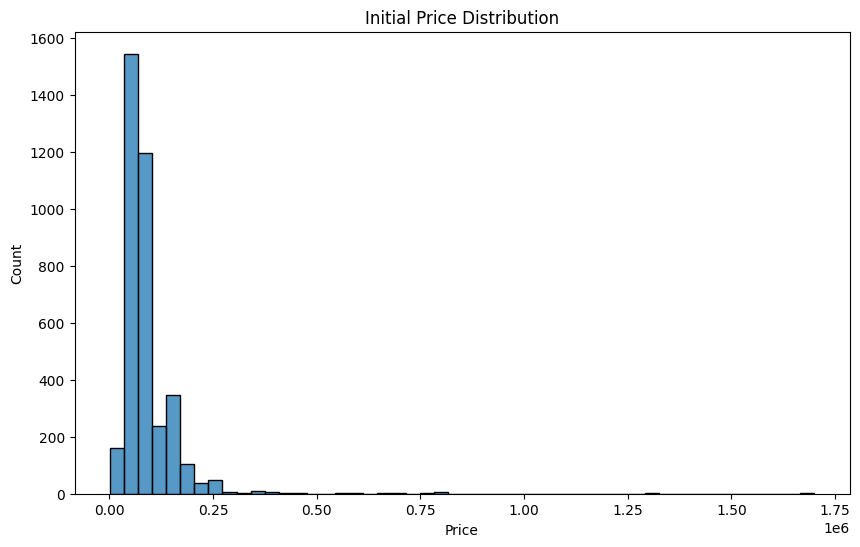

In [12]:
# Cell 1: Initial Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = [10, 6]

def load_data(file_path):
    """Load and perform initial data inspection"""
    df = pd.read_csv(file_path)
    
    # Basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]}")
    
    # Check missing values
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        print(missing[missing > 0])
    else:
        print("\nNo missing values found")
    
    # Display key statistics
    key_features = ['price', 'size', 'bedrooms', 'bathrooms']
    print("\nKey Features Statistics:")
    print("-" * 50)
    print(df[key_features].describe())
    
    return df

# Load data
df = load_data('SA_Aqar.csv')

# Visualize initial price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', bins=50)
plt.title('Initial Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

Starting data cleaning...
Initial shape: (3718, 24)
Removing 326 outliers from size


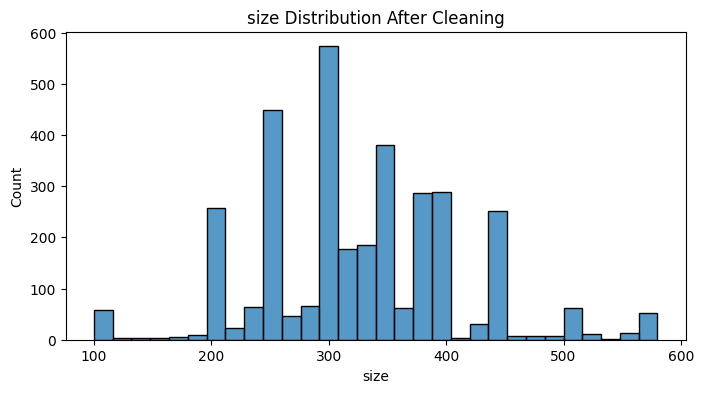

Removing 0 outliers from bedrooms


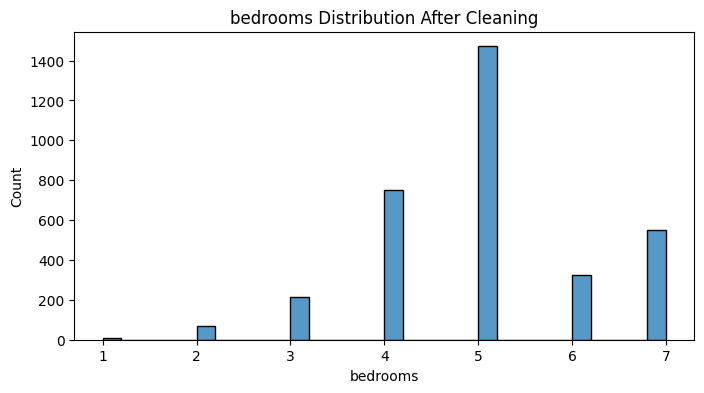

Removing 68 outliers from bathrooms


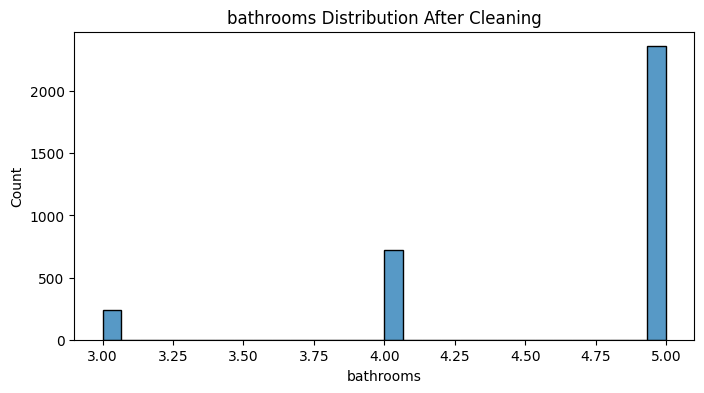

Removing 89 outliers from livingrooms


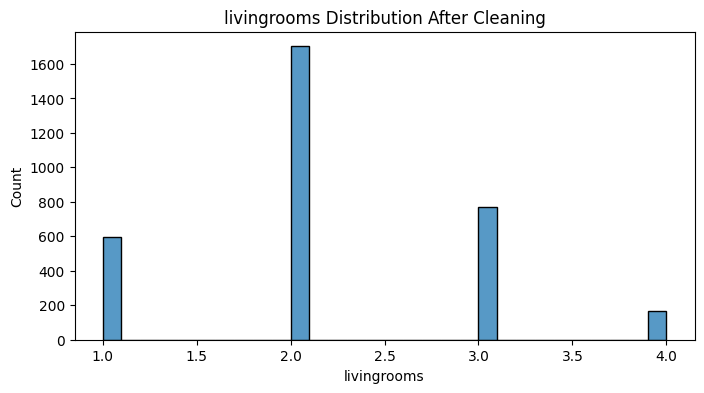

Removing 165 outliers from price

Removed 0 rows with missing values

Final shape: (3070, 24)
Retained 82.6% of original data


Text(0.5, 1.0, 'Price Distribution After Cleaning')

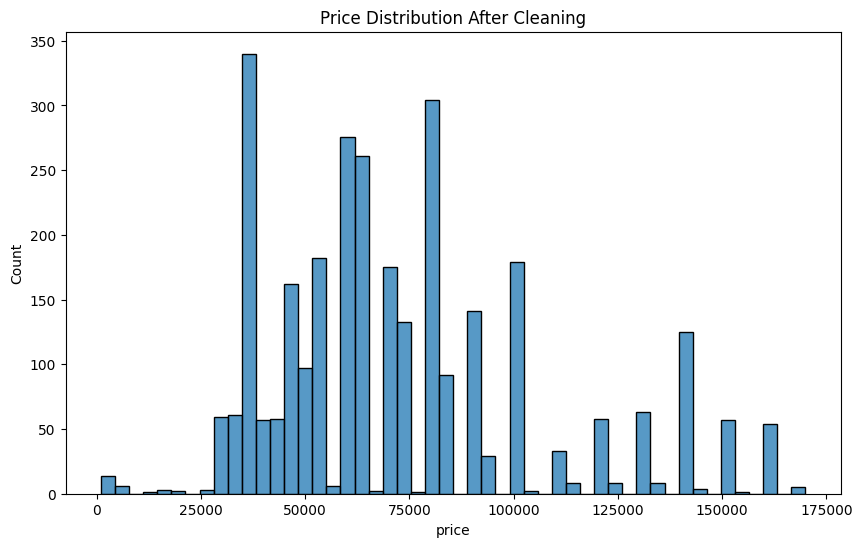

In [13]:
# Cell 2: Data Cleaning
def clean_data(df):
    """Clean data with focus on key features"""
    print("Starting data cleaning...")
    print(f"Initial shape: {df.shape}")
    
    df_clean = df.copy()
    
    # Core features to clean
    numeric_features = [
        'price',      # Target variable
        'size',       # Property size
        'bedrooms',   # Number of bedrooms
        'bathrooms',  # Number of bathrooms
        'livingrooms' # Number of living rooms
    ]
    
    # Convert numeric features
    for col in numeric_features:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Remove outliers function
    def remove_outliers(df, column, factor=1.5):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
        print(f"Removing {outliers:,} outliers from {column}")
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    # Clean each numeric feature
    for col in numeric_features:
        if col != 'price':  # Handle price separately
            df_clean = remove_outliers(df_clean, col)
            
            # Show distribution after cleaning
            plt.figure(figsize=(8, 4))
            sns.histplot(data=df_clean, x=col, bins=30)
            plt.title(f'{col} Distribution After Cleaning')
            plt.show()
    
    # Handle price outliers last
    df_clean = remove_outliers(df_clean, 'price', factor=2.0)  # More lenient with price
    
    # Remove any remaining NaN values
    initial_rows = len(df_clean)
    df_clean = df_clean.dropna(subset=numeric_features)
    rows_dropped = initial_rows - len(df_clean)
    print(f"\nRemoved {rows_dropped:,} rows with missing values")
    
    print(f"\nFinal shape: {df_clean.shape}")
    print(f"Retained {len(df_clean)/len(df)*100:.1f}% of original data")
    
    return df_clean

# Clean the data
df_cleaned = clean_data(df)

# Show final price distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='price', bins=50)
plt.title('Price Distribution After Cleaning')

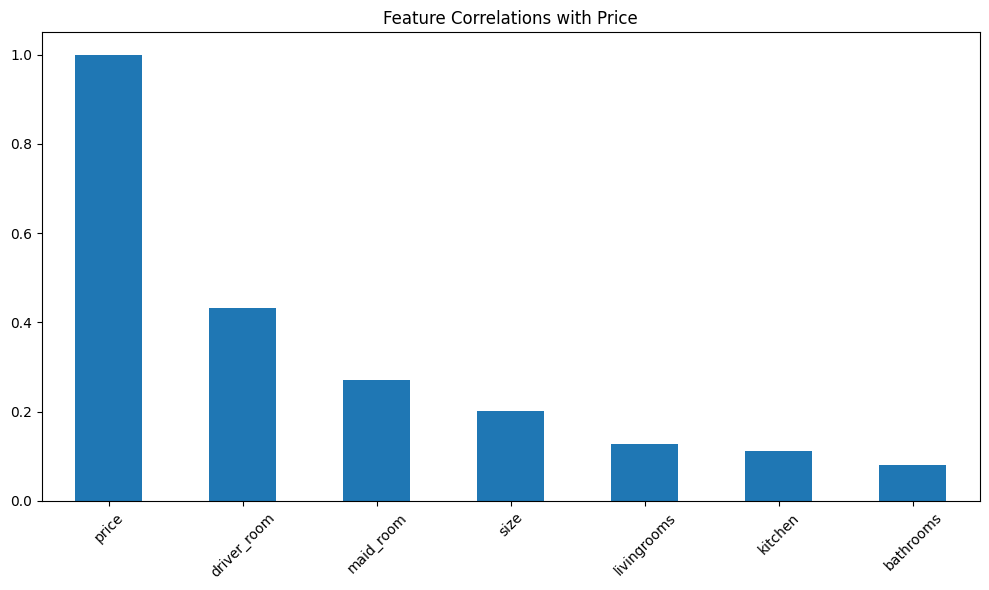

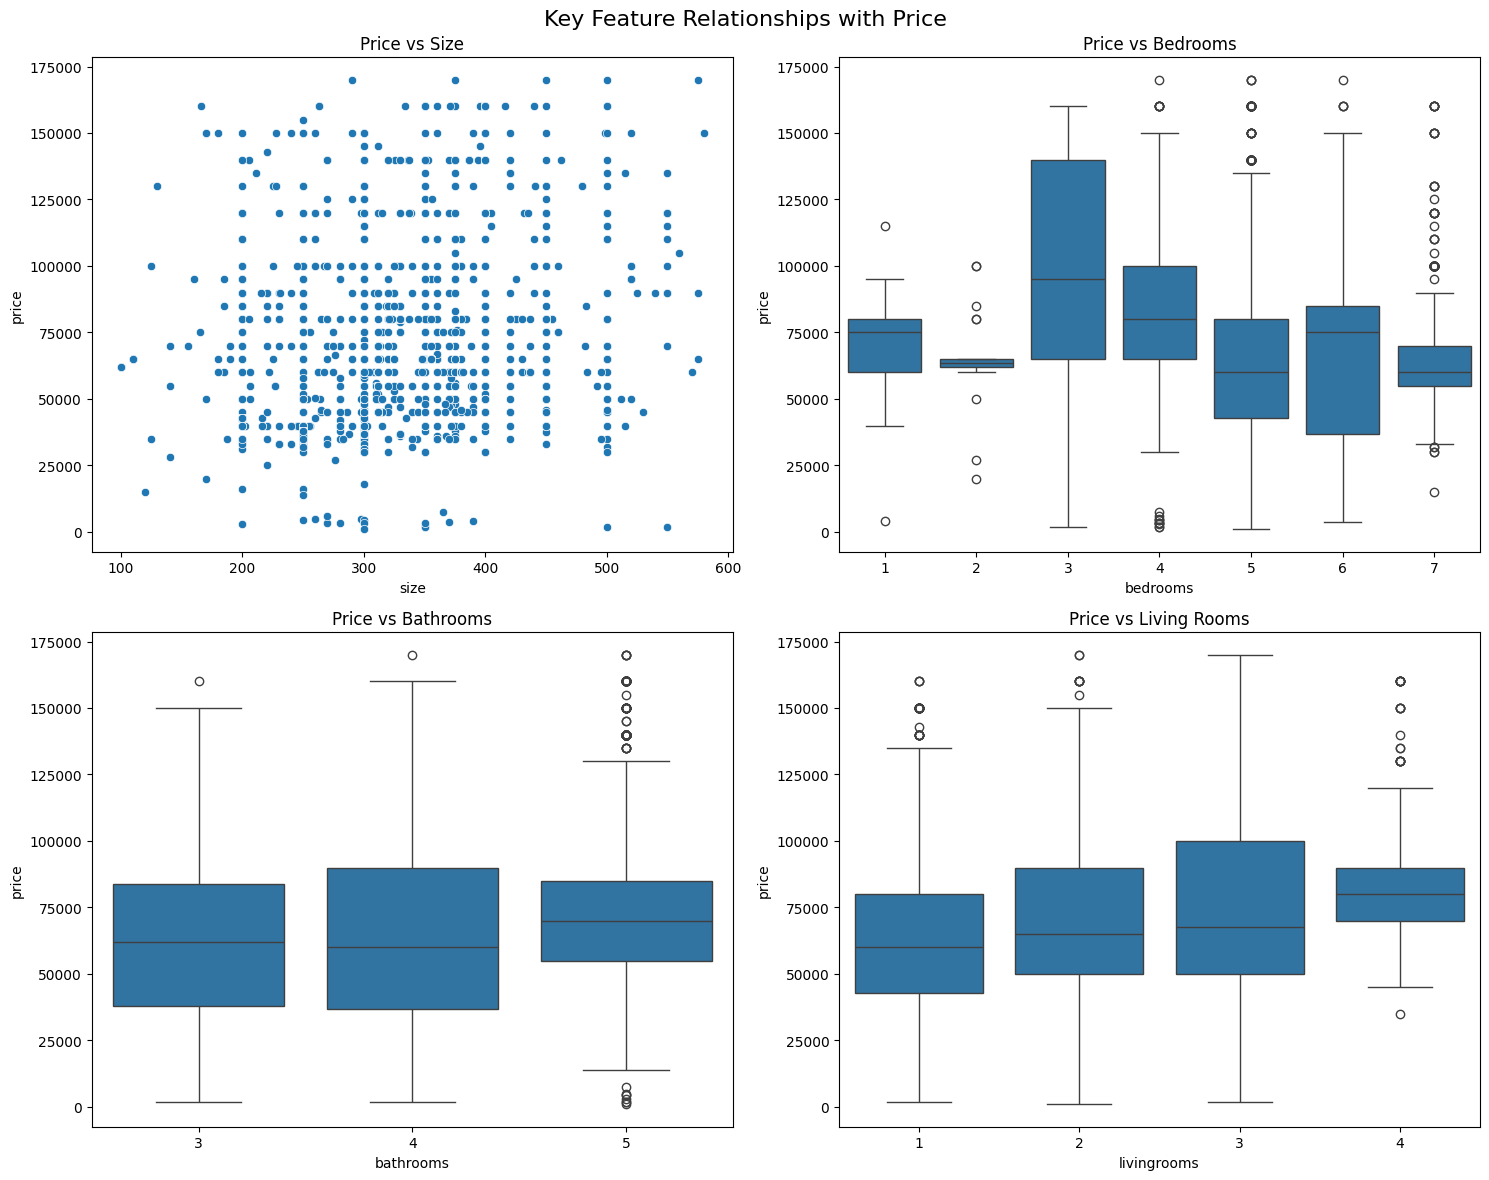


Feature Correlations with Price:
--------------------------------------------------
driver_room  :  0.4334
maid_room    :  0.2711
size         :  0.2017
livingrooms  :  0.1276
kitchen      :  0.1115
bathrooms    :  0.0804
bedrooms     : -0.1669


In [14]:
# Cell 3: Feature Analysis
def analyze_features(df):
    """Analyze individual feature importance and relationships"""
    # Core features to analyze
    features = [
        'size',
        'bedrooms',
        'bathrooms',
        'livingrooms',
        'driver_room',
        'maid_room',
        'kitchen'
    ]
    
    # 1. Correlation with price
    correlations = df[features + ['price']].corr()['price'].sort_values(ascending=False)
    
    # Plot correlations
    plt.figure(figsize=(10, 6))
    correlations[:-1].plot(kind='bar')  # Exclude price itself
    plt.title('Feature Correlations with Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Individual feature relationships with price
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Key Feature Relationships with Price', fontsize=16)
    
    # Size vs Price (most important)
    sns.scatterplot(data=df, x='size', y='price', ax=axes[0,0])
    axes[0,0].set_title('Price vs Size')
    
    # Bedrooms vs Price
    sns.boxplot(data=df, x='bedrooms', y='price', ax=axes[0,1])
    axes[0,1].set_title('Price vs Bedrooms')
    
    # Bathrooms vs Price
    sns.boxplot(data=df, x='bathrooms', y='price', ax=axes[1,0])
    axes[1,0].set_title('Price vs Bathrooms')
    
    # Living Rooms vs Price
    sns.boxplot(data=df, x='livingrooms', y='price', ax=axes[1,1])
    axes[1,1].set_title('Price vs Living Rooms')
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation values
    print("\nFeature Correlations with Price:")
    print("-" * 50)
    for feature, corr in correlations.items():
        if feature != 'price':
            print(f"{feature:12} : {corr:7.4f}")
    
    return correlations

# Analyze features
feature_correlations = analyze_features(df_cleaned)

In [15]:
# Cell 4: Prepare Data for Modeling
def prepare_data(df):
    """Prepare features for modeling"""
    # Select features based on correlation analysis
    numeric_features = [
        'size',
        'bedrooms',
        'bathrooms',
        'livingrooms',
        'driver_room',
        'maid_room',
        'kitchen'
    ]
    
    # Encode categorical features
    categorical_features = ['city', 'front', 'property_age']
    le = LabelEncoder()
    
    # Create feature matrix
    X = df[numeric_features].copy()
    
    # Add encoded categorical features
    for col in categorical_features:
        X[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    
    # Target variable
    y = df['price']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to DataFrame to maintain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    
    print("Data Preparation Summary:")
    print("-" * 50)
    print(f"Training set shape: {X_train_scaled.shape}")
    print(f"Testing set shape: {X_test_scaled.shape}")
    print(f"\nFeatures used: {list(X_train_scaled.columns)}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Prepare data for modeling
X_train, X_test, y_train, y_test, scaler = prepare_data(df_cleaned)

Data Preparation Summary:
--------------------------------------------------
Training set shape: (2456, 10)
Testing set shape: (614, 10)

Features used: ['size', 'bedrooms', 'bathrooms', 'livingrooms', 'driver_room', 'maid_room', 'kitchen', 'city_encoded', 'front_encoded', 'property_age_encoded']


Training model...
Making predictions...

Model Performance Metrics:
--------------------------------------------------
Train R²  : 0.77
Test R²   : 0.63
Train RMSE: 15,399.41
Test RMSE : 20,306.89
Train MAE : 9,146.48
Test MAE  : 11,684.61


<Figure size 1000x600 with 0 Axes>

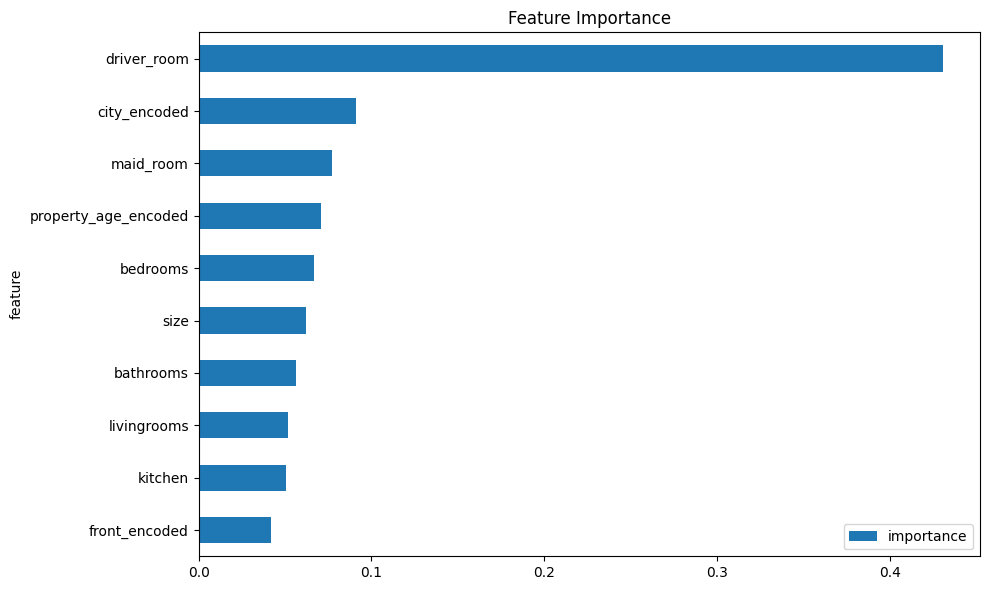

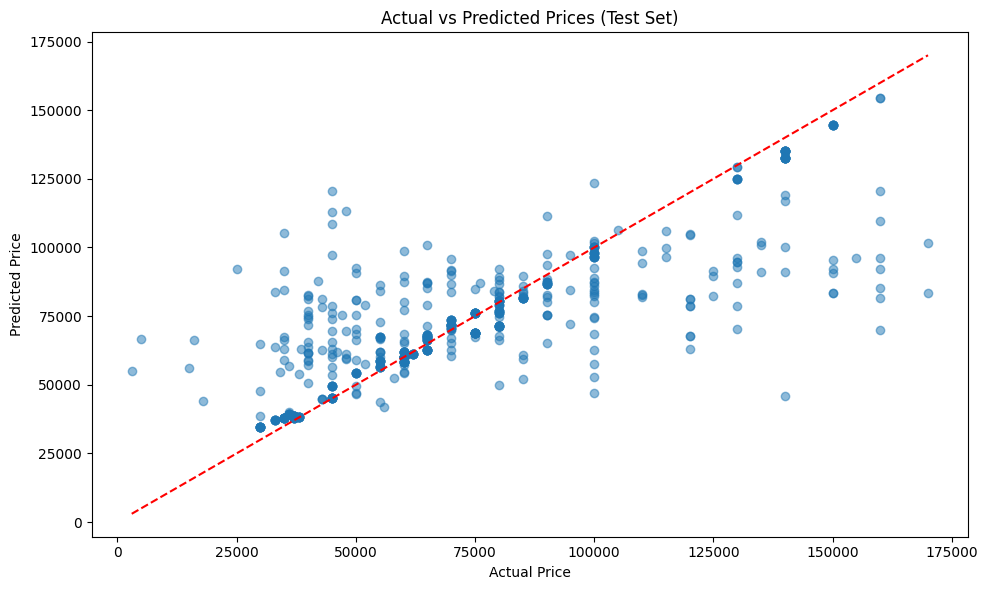


Model and scaler saved to disk

Top 5 Most Important Features:
--------------------------------------------------
                feature  importance
4           driver_room    0.430562
7          city_encoded    0.091308
5             maid_room    0.076901
9  property_age_encoded    0.071003
1              bedrooms    0.066920


In [16]:
# Cell 5: Model Training and Evaluation
def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    """Train and evaluate XGBoost model"""
    # Model parameters
    params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 5,
        'min_child_weight': 2,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'random_state': 42
    }
    
    # Initialize and train model
    print("Training model...")
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Make predictions
    print("Making predictions...")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    metrics = {
        'Train R²': r2_score(y_train, y_pred_train),
        'Test R²': r2_score(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test)
    }
    
    # Print metrics
    print("\nModel Performance Metrics:")
    print("-" * 50)
    for metric, value in metrics.items():
        print(f"{metric:10}: {value:,.2f}")
    
    # Plot feature importance
    importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 6))
    importance.plot(kind='barh', x='feature', y='importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual vs Predicted Prices (Test Set)')
    plt.tight_layout()
    plt.show()
    
    return model, metrics, importance

# Train and evaluate model
model, metrics, feature_importance = train_and_evaluate_model(X_train, X_test, y_train, y_test)

# Save model and scaler
import joblib
joblib.dump(model, 'house_price_model.pkl')
joblib.dump(scaler, 'house_price_scaler.pkl')
print("\nModel and scaler saved to disk")

# Display top 5 most important features
print("\nTop 5 Most Important Features:")
print("-" * 50)
print(feature_importance.sort_values('importance', ascending=False).head())

In [17]:
# Cell 6: Model Prediction and Usage Examples
def predict_price(model, scaler, input_data):
    """Predict house price based on input features"""
    # Prepare input data
    input_df = pd.DataFrame(input_data, index=[0])
    
    # Scale features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    predicted_price = model.predict(input_scaled)
    
    return predicted_price[0]

# Example usage
example_input = {
    'size': 200,          # Size in square meters
    'bedrooms': 5,        # Number of bedrooms
    'bathrooms': 4,       # Number of bathrooms
    'livingrooms': 1,     # Number of living rooms
    'driver_room': 0,    # Driver room presence (1 or 0)
    'maid_room': 1,       # Maid room presence (1 or 0)
    'kitchen': 1,         # Kitchen presence (1 or 0)
    'city_encoded': 2,    # Encoded city value
    'front_encoded': 1,   # Encoded front value
    'property_age_encoded': 5 # Encoded property age value
}

# Predict price
predicted_price = predict_price(model, scaler, example_input)
print(f"\nPredicted Price: {predicted_price:,.2f} SAR")



Predicted Price: 83,568.39 SAR
